In [1]:
import pandas as pd

file_paths = [
    'telegram_messages_originalbullbull_20241206_111436.csv',
    'telegram_messages_STOCKGAINERSS_20241206_111436.csv',
    'telegram_messages_TheWealthMagnet_20241206_111436.csv',
    'telegram_messages_the_trading_advisor_stock_20241206_111436.csv'
]


dataframes = [pd.read_csv(file_path) for file_path in file_paths]
merged_df = pd.concat(dataframes, ignore_index=True)


merged_df.info(), merged_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     4000 non-null   object
 1   Sender   4000 non-null   int64 
 2   Message  3666 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


(None,
                         Date         Sender  \
 0  2024-12-06 05:40:57+00:00 -1001843670580   
 1  2024-12-06 05:40:04+00:00 -1001843670580   
 2  2024-12-06 04:37:40+00:00 -1001843670580   
 3  2024-12-06 04:21:02+00:00 -1001843670580   
 4  2024-12-06 04:15:33+00:00 -1001843670580   
 
                                              Message  
 0                                 Sideways ❤️👍👍❤️❤️👍  
 1                                               J...  
 2                                   0 POINT RATE CUT  
 3  nifty important resistance trendline❤️❤️👍❤️❤️👍👍❤️  
 4  Range is big and current momentum is slow. \n\...  )

# As we can see the merged dataset contains 4,000 entries with three columns: Date, Sender, and Message. The Message column has some missing values, which I will address during preprocessing.

In [2]:
import re


merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
cleaned_df = merged_df.dropna(subset=['Message', 'Date']).reset_index(drop=True)
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text)

cleaned_df['Message'] = cleaned_df['Message'].apply(clean_text)
cleaned_df.info(), cleaned_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3666 entries, 0 to 3665
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   Date     3666 non-null   datetime64[ns, UTC]
 1   Sender   3666 non-null   int64              
 2   Message  3666 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 86.1+ KB


(None,
                        Date         Sender  \
 0 2024-12-06 05:40:57+00:00 -1001843670580   
 1 2024-12-06 05:40:04+00:00 -1001843670580   
 2 2024-12-06 04:37:40+00:00 -1001843670580   
 3 2024-12-06 04:21:02+00:00 -1001843670580   
 4 2024-12-06 04:15:33+00:00 -1001843670580   
 
                                              Message  
 0                                          Sideways   
 1                                                  J  
 2                                   0 POINT RATE CUT  
 3               nifty important resistance trendline  
 4  Range is big and current momentum is slow \n\n...  )

# Now i will try to give sentiment values to the messages.

In [3]:
!pip install textblob

In [4]:
from textblob import TextBlob

def analyze_sentiment(message):
    blob = TextBlob(message)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to the 'Message' column
cleaned_df['Polarity'], cleaned_df['Subjectivity'] = zip(*cleaned_df['Message'].apply(analyze_sentiment))
cleaned_df[['Message', 'Polarity', 'Subjectivity']].head()

,Message,Polarity,Subjectivity
0,Sideways,0.00,0.000000
1,J,0.00,0.000000
2,0 POINT RATE CUT,0.00,0.000000
3,nifty important resistance trendline,0.40,1.000000
4,Range is big and current momentum is slow \n\n...,-0.05,0.320833


## In the sentiment analysis I have converted into two columns polarity and subjectivity.

1. Polarity: Sentiment score of the message:

    ->0.00 indicates neutral sentiment.

    ->Positive values indicate positive sentiment.
    
    ->Negative values indicate negative sentiment.
    
2. Subjectivity: How subjective or opinionated the message is (0 to 1).


In [5]:

keywords = ['profit', 'loss', 'target', 'buy', 'sell']
for keyword in keywords:
    cleaned_df[f'Keyword_{keyword}'] = cleaned_df['Message'].str.contains(keyword, case=False, na=False).astype(int)


cleaned_df['Message_Length'] = cleaned_df['Message'].str.len()
cleaned_df['Word_Count'] = cleaned_df['Message'].str.split().str.len()

cleaned_df['Capital_Words_Count'] = cleaned_df['Message'].str.findall(r'\b[A-Z]{2,}\b').str.len()
cleaned_df[['Message', 'Message_Length', 'Word_Count', 'Capital_Words_Count'] + [f'Keyword_{k}' for k in keywords]].head()


,Message,Message_Length,Word_Count,Capital_Words_Count,Keyword_profit,Keyword_loss,Keyword_target,Keyword_buy,Keyword_sell
0,Sideways,9,1,0,0,0,0,0,0
1,J,1,1,0,0,0,0,0,0
2,0 POINT RATE CUT,16,4,3,0,0,0,0,0
3,nifty important resistance trendline,36,4,0,0,0,0,0,0
4,Range is big and current momentum is slow \n\n...,119,21,1,0,0,0,0,0


## Feature Extraction

In [6]:

keywords = ['profit', 'loss', 'target', 'buy', 'sell']
for keyword in keywords:
    cleaned_df[f'Keyword_{keyword}'] = cleaned_df['Message'].str.contains(keyword, case=False, na=False).astype(int)
cleaned_df['Message_Length'] = cleaned_df['Message'].str.len()
cleaned_df['Word_Count'] = cleaned_df['Message'].str.split().str.len()
cleaned_df['Capital_Words_Count'] = cleaned_df['Message'].str.findall(r'\b[A-Z]{2,}\b').str.len()
print(cleaned_df[['Message', 'Message_Length', 'Word_Count', 'Capital_Words_Count'] + [f'Keyword_{k}' for k in keywords]].head())


                                             Message  Message_Length  \
0                                          Sideways                9   
1                                                  J               1   
2                                   0 POINT RATE CUT              16   
3               nifty important resistance trendline              36   
4  Range is big and current momentum is slow \n\n...             119   

   Word_Count  Capital_Words_Count  Keyword_profit  Keyword_loss  \
0           1                    0               0             0   
1           1                    0               0             0   
2           4                    3               0             0   
3           4                    0               0             0   
4          21                    1               0             0   

   Keyword_target  Keyword_buy  Keyword_sell  
0               0            0             0  
1               0            0             0  
2               0

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_features = ['Message_Length', 'Word_Count', 'Capital_Words_Count'] + [f'Keyword_{k}' for k in keywords]
cleaned_df[numeric_features] = scaler.fit_transform(cleaned_df[numeric_features])


In [8]:
cleaned_df.head()

,Date,Sender,Message,Polarity,Subjectivity,Keyword_profit,Keyword_loss,Keyword_target,Keyword_buy,Keyword_sell,Message_Length,Word_Count,Capital_Words_Count
0,2024-12-06 05:40:57+00:00,-1001843670580,Sideways,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.007075,0.004831,0.000000
1,2024-12-06 05:40:04+00:00,-1001843670580,J,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000786,0.004831,0.000000
2,2024-12-06 04:37:40+00:00,-1001843670580,0 POINT RATE CUT,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.012579,0.019324,0.062500
3,2024-12-06 04:21:02+00:00,-1001843670580,nifty important resistance trendline,0.40,1.000000,0.0,0.0,0.0,0.0,0.0,0.028302,0.019324,0.000000
4,2024-12-06 04:15:33+00:00,-1001843670580,Range is big and current momentum is slow \n\n...,-0.05,0.320833,0.0,0.0,0.0,0.0,0.0,0.093553,0.101449,0.020833


## Performing Exploratory Data Analysis (EDA)

In [9]:
print("Data Overview:")
print(cleaned_df.info())
print("\nSummary Statistics:")
print(cleaned_df.describe())
print("\nMissing Values:")
print(cleaned_df.isnull().sum())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3666 entries, 0 to 3665
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Date                 3666 non-null   datetime64[ns, UTC]
 1   Sender               3666 non-null   int64              
 2   Message              3666 non-null   object             
 3   Polarity             3666 non-null   float64            
 4   Subjectivity         3666 non-null   float64            
 5   Keyword_profit       3666 non-null   float64            
 6   Keyword_loss         3666 non-null   float64            
 7   Keyword_target       3666 non-null   float64            
 8   Keyword_buy          3666 non-null   float64            
 9   Keyword_sell         3666 non-null   float64            
 10  Message_Length       3666 non-null   float64            
 11  Word_Count           3666 non-null   float64            
 12  Capit

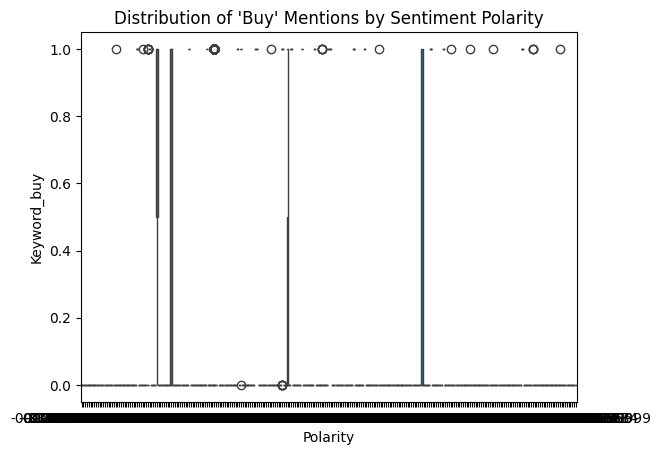

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Polarity', y='Keyword_buy', data=cleaned_df)
plt.title("Distribution of 'Buy' Mentions by Sentiment Polarity")
plt.show()


In [11]:
print(cleaned_df.columns)

Index(['Date', 'Sender', 'Message', 'Polarity', 'Subjectivity',
       'Keyword_profit', 'Keyword_loss', 'Keyword_target', 'Keyword_buy',
       'Keyword_sell', 'Message_Length', 'Word_Count', 'Capital_Words_Count'],
      dtype='object')


Distribution of Sentiment Polarity

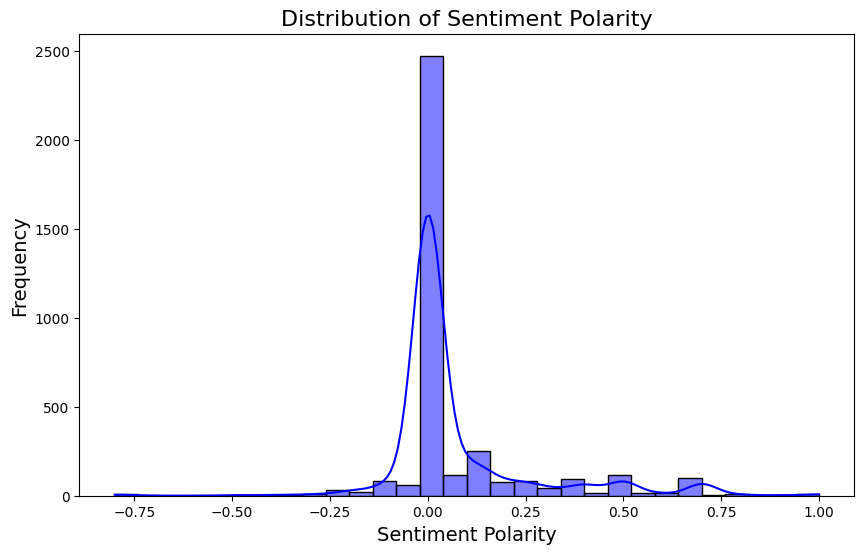

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['Polarity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentiment Polarity', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

##  Frequency of Messages by Date

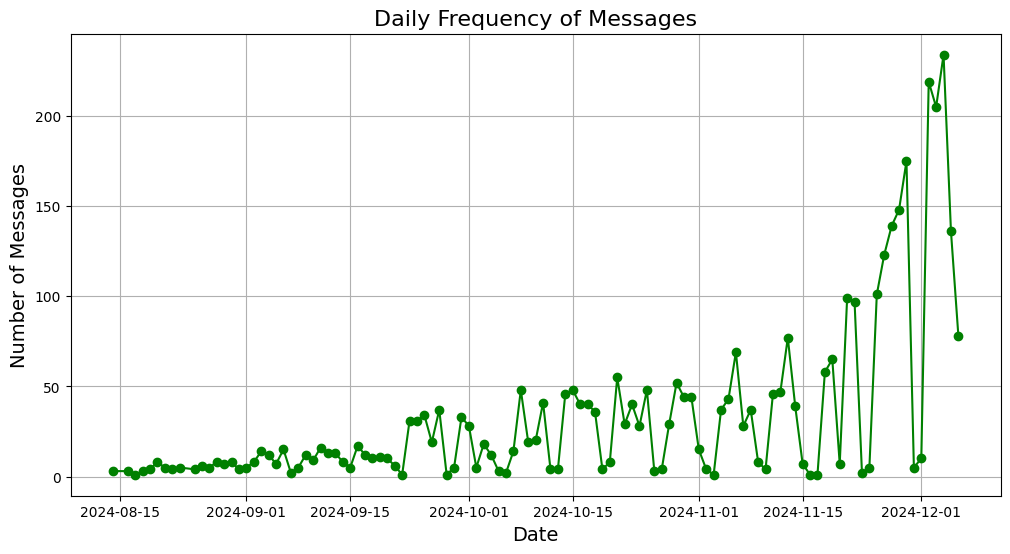

In [13]:

cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])
daily_messages = cleaned_df.groupby(cleaned_df['Date'].dt.date).size()

plt.figure(figsize=(12, 6))
daily_messages.plot(kind='line', marker='o', color='green')
plt.title('Daily Frequency of Messages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14)
plt.grid()
plt.show()


Keyword Mention Analysis

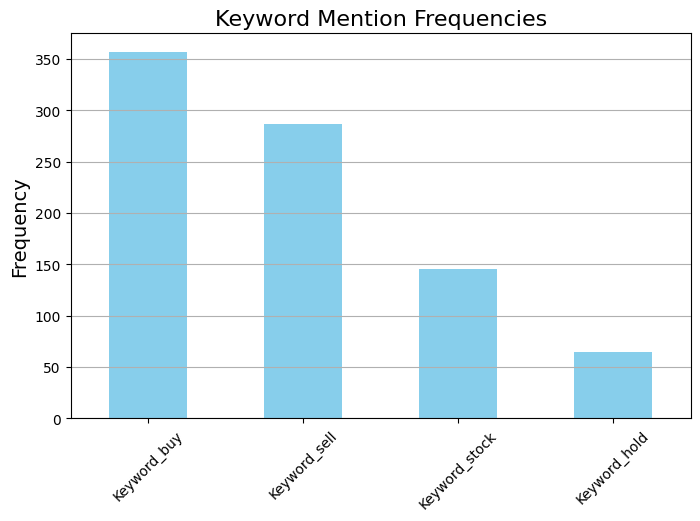

In [14]:
keywords = ['buy', 'sell', 'stock', 'hold']
for keyword in keywords:
    cleaned_df[f'Keyword_{keyword}'] = cleaned_df['Message'].apply(lambda x: keyword in str(x).lower())


keyword_counts = cleaned_df[[f'Keyword_{kw}' for kw in keywords]].sum()

plt.figure(figsize=(8, 5))
keyword_counts.plot(kind='bar', color='skyblue')
plt.title('Keyword Mention Frequencies', fontsize=16)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Relationship Between Sentiment and Keyword Mentions

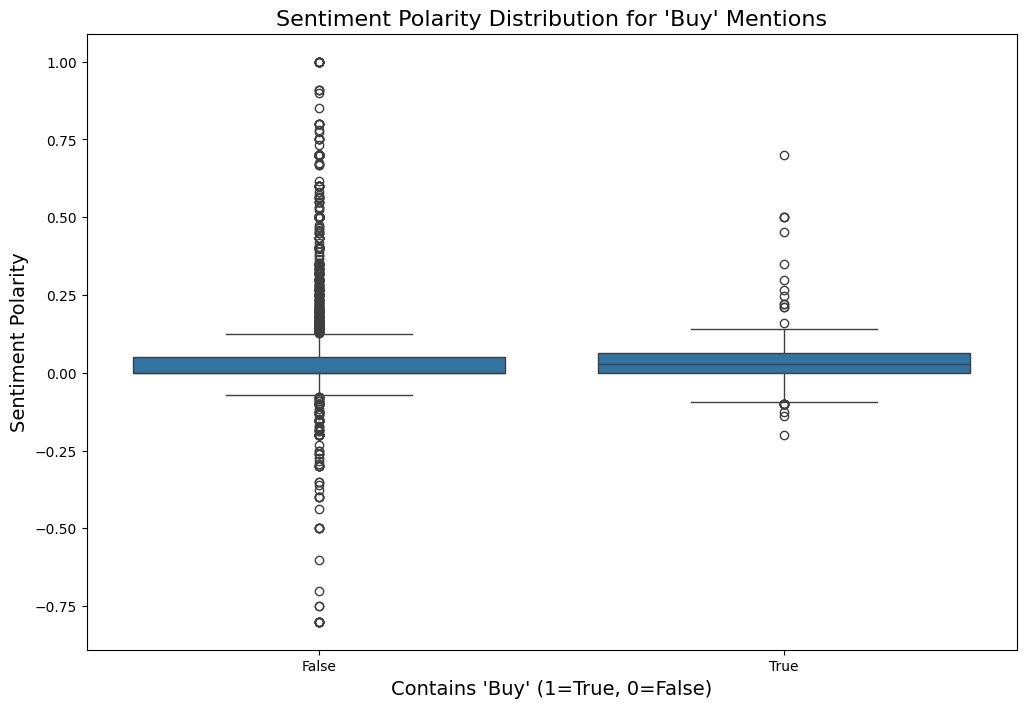

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Keyword_buy', y='Polarity', data=cleaned_df)
plt.title("Sentiment Polarity Distribution for 'Buy' Mentions", fontsize=16)
plt.xlabel("Contains 'Buy' (1=True, 0=False)", fontsize=14)
plt.ylabel("Sentiment Polarity", fontsize=14)
plt.show()


Heatmap of Feature Correlations

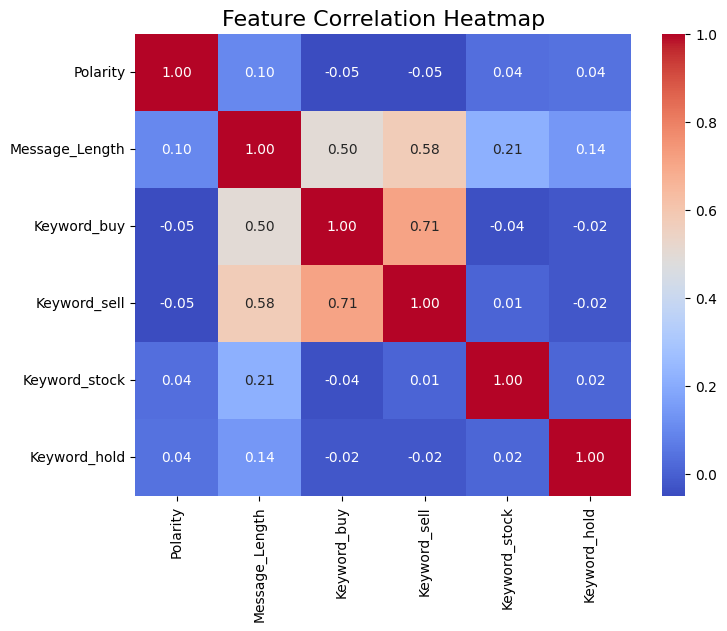

In [16]:
# Select numerical features for correlation
correlation_features = ['Polarity', 'Message_Length'] + [f'Keyword_{kw}' for kw in keywords]
correlation_matrix = cleaned_df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

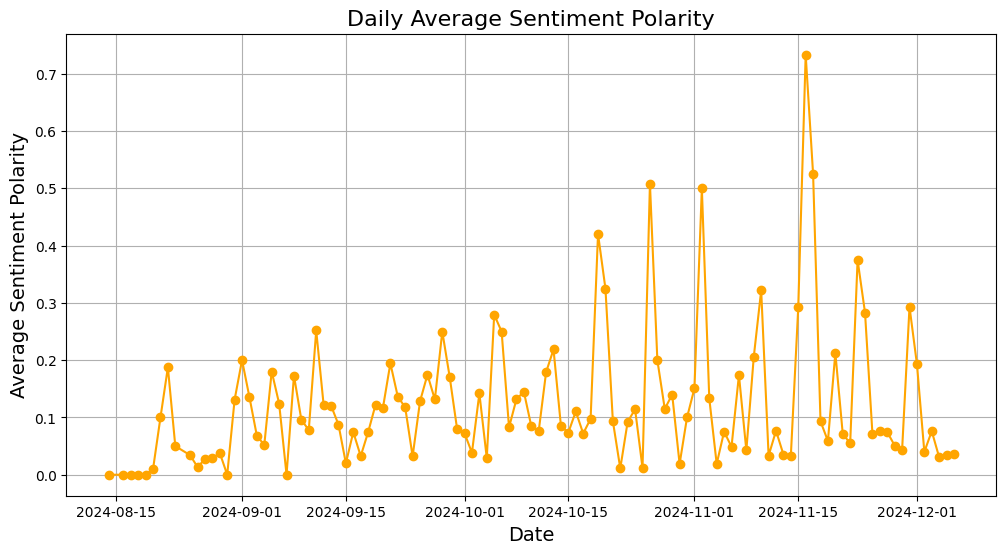

In [17]:
daily_sentiment = cleaned_df.groupby(cleaned_df['Date'].dt.date)['Polarity'].mean()

plt.figure(figsize=(12, 6))
daily_sentiment.plot(kind='line', marker='o', color='orange')
plt.title('Daily Average Sentiment Polarity', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Sentiment Polarity', fontsize=14)
plt.grid()
plt.show()

Outliers in Sentiment Polarity

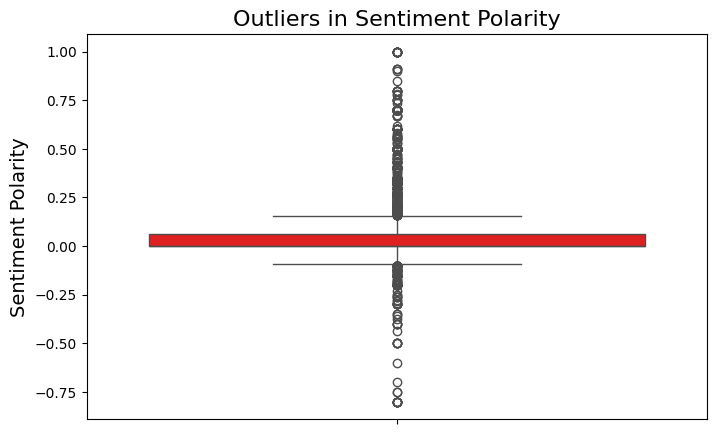

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(y='Polarity', data=cleaned_df, color='red')
plt.title('Outliers in Sentiment Polarity', fontsize=16)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.show()

In [19]:
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])
aggregated_data = cleaned_df.groupby(cleaned_df['Date'].dt.date).agg({
    'Polarity': 'mean',
    'Keyword_buy': 'sum',
    'Keyword_sell': 'sum',
    'Word_Count': 'mean',
}).reset_index()

In [22]:
cleaned_df.head(100)
cleaned_df.to_csv('final.csv', index=False)


In [24]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 8.6 MB/s eta 0:00:0000:0100:01


Basic Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Stock Name      246 non-null    object 
 1   Symbol          246 non-null    object 
 2   Recommendation  246 non-null    object 
 3   CMP             246 non-null    float64
 4   Stop Loss       239 non-null    float64
 5   Target          189 non-null    float64
 6   Duration        246 non-null    object 
 7   Sentiment       246 non-null    float64
 8   Stock Movement  246 non-null    object 
dtypes: float64(4), object(5)
memory usage: 17.4+ KB
None

Descriptive Statistics
                CMP     Stop Loss        Target   Sentiment
count    246.000000    239.000000    189.000000  246.000000
mean     910.739837    825.313808    817.767196   -0.012751
std     1702.197844   1538.259864   1734.874552    0.096592
min        2.000000      1.000000      7.000000   -0.285185
2

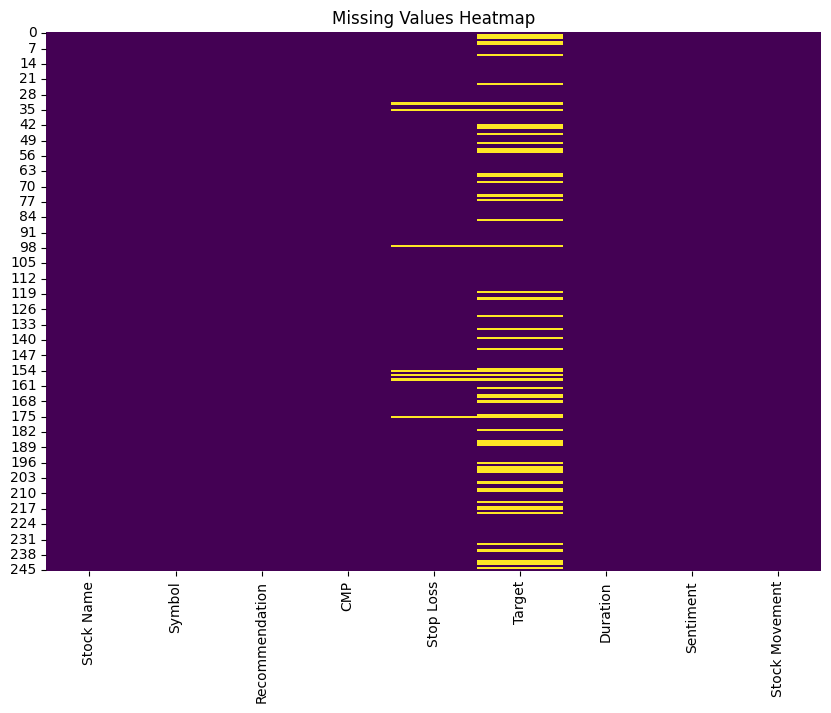

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('stock_analysis.csv') 



print("\nDescriptive Statistics")
print(df.describe())


print("\nMissing Values Analysis")
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
print(missing_df[missing_df['Percentage'] > 0])


plt.figure(figsize=(10, 7))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()



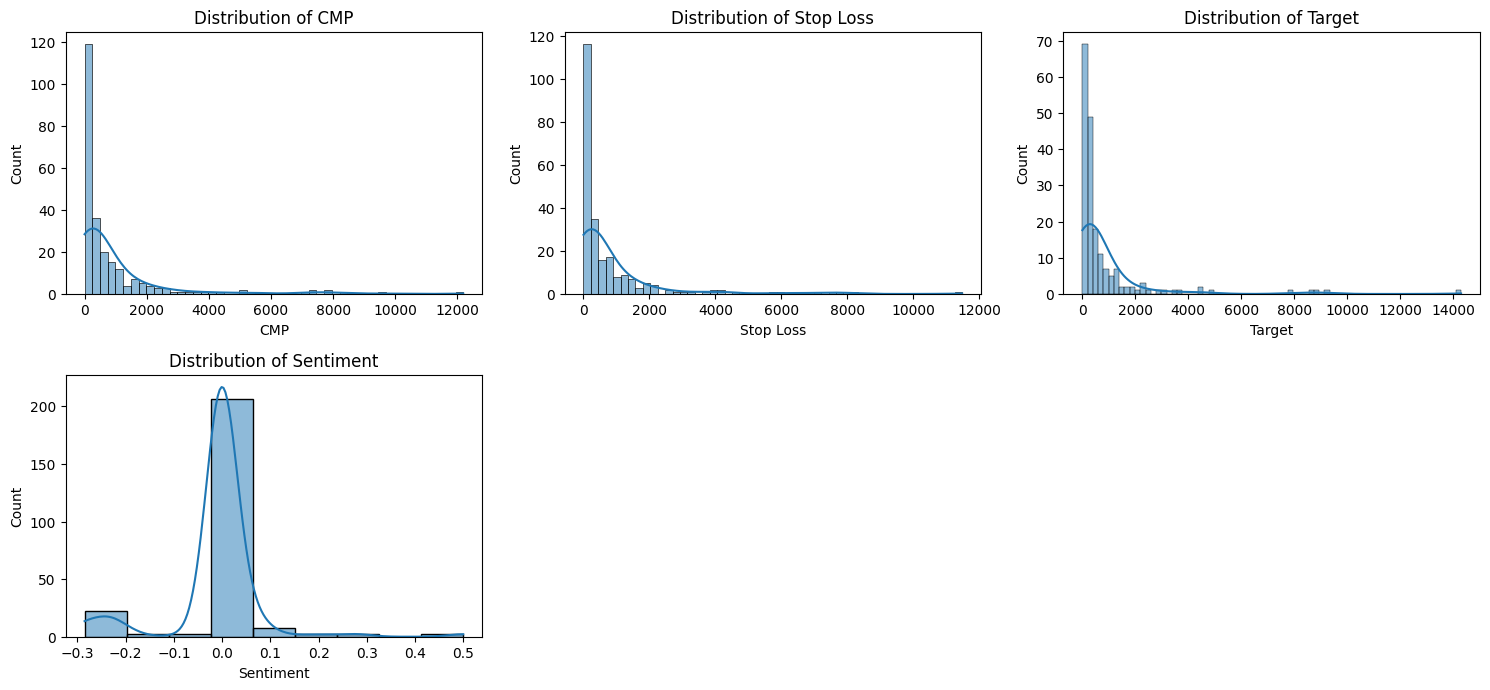

In [26]:
numerical_features = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



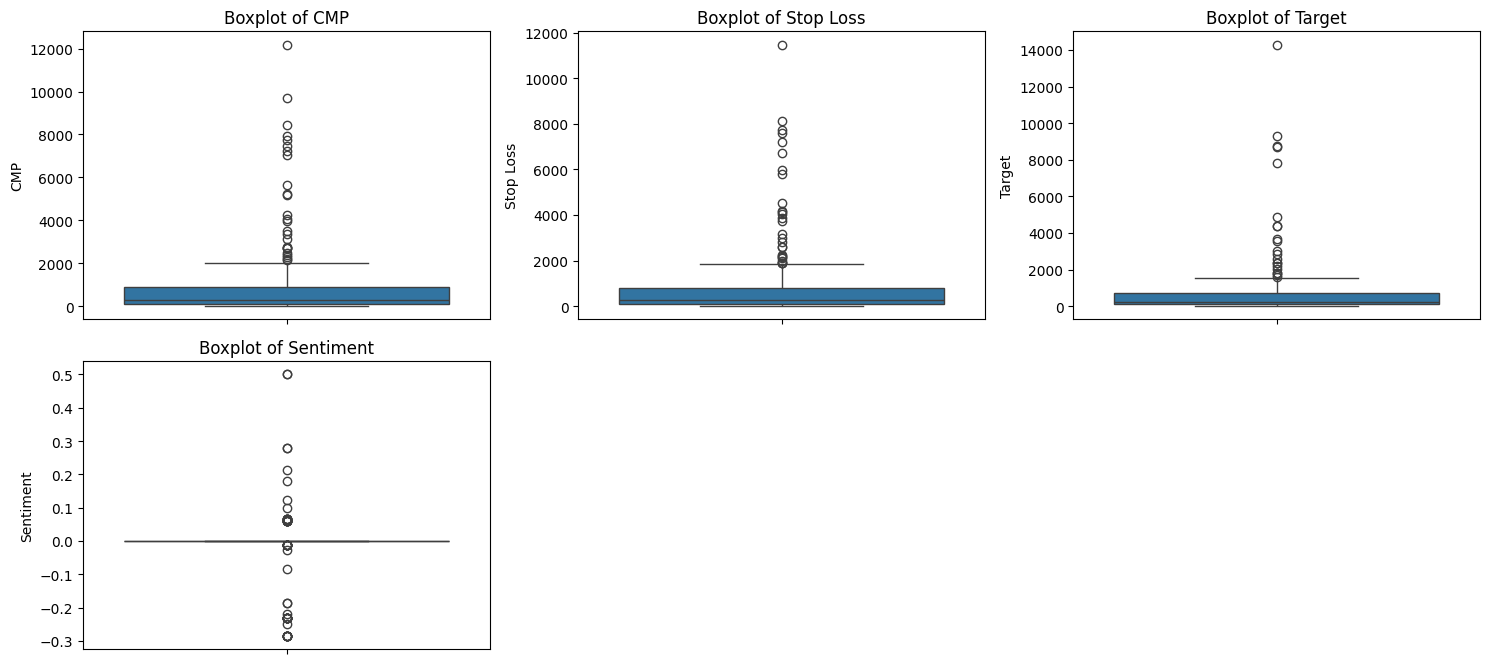

In [27]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


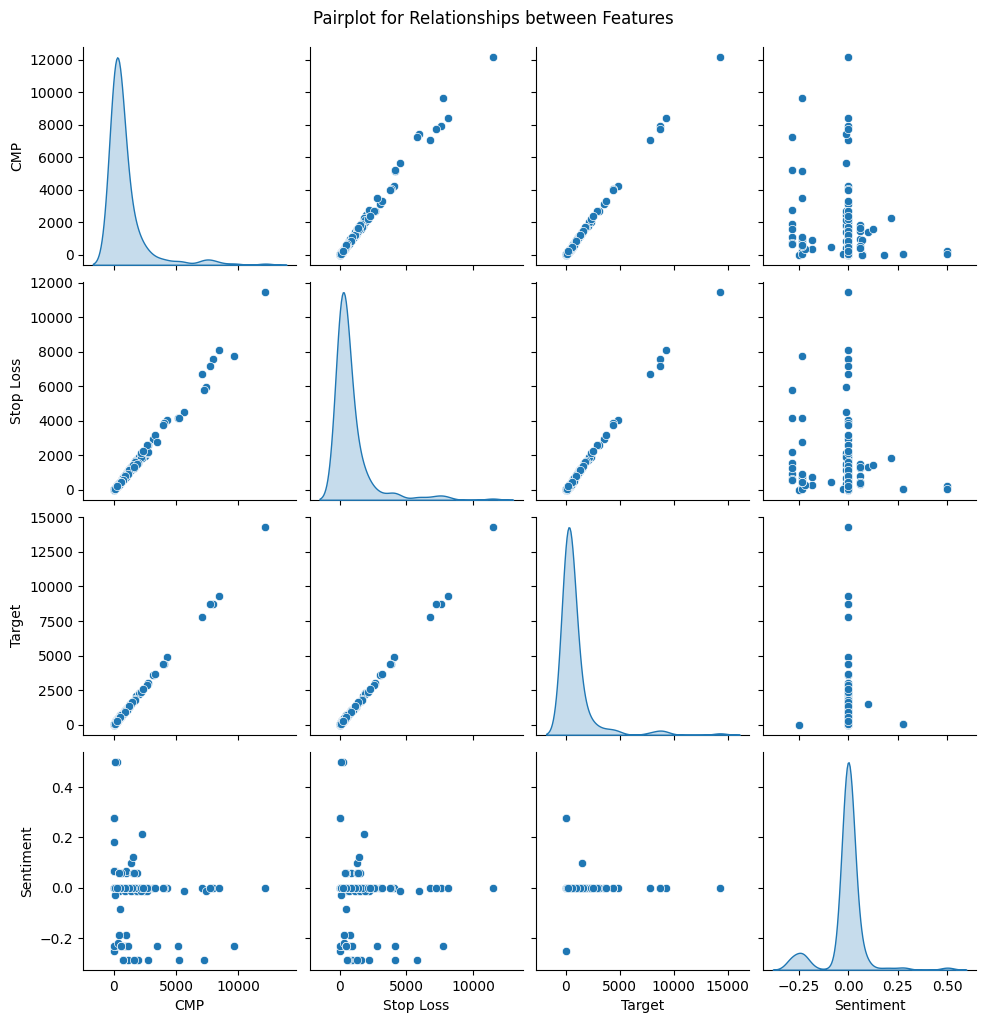

In [29]:
sns.pairplot(df, diag_kind='kde')
plt.suptitle('Pairplot for Relationships between Features', y=1.02)
plt.show()

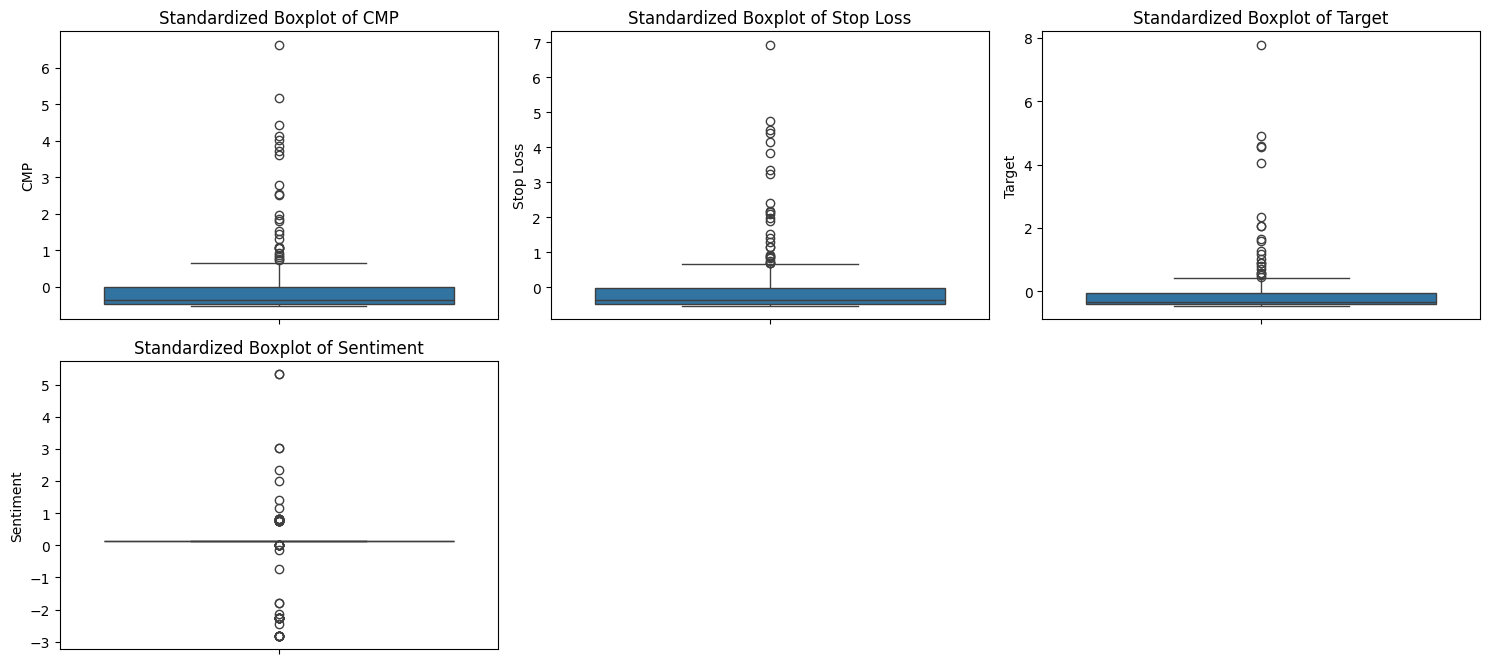

In [30]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(scaled_df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(scaled_df[feature])
    plt.title(f'Standardized Boxplot of {feature}')
plt.tight_layout()
plt.show()

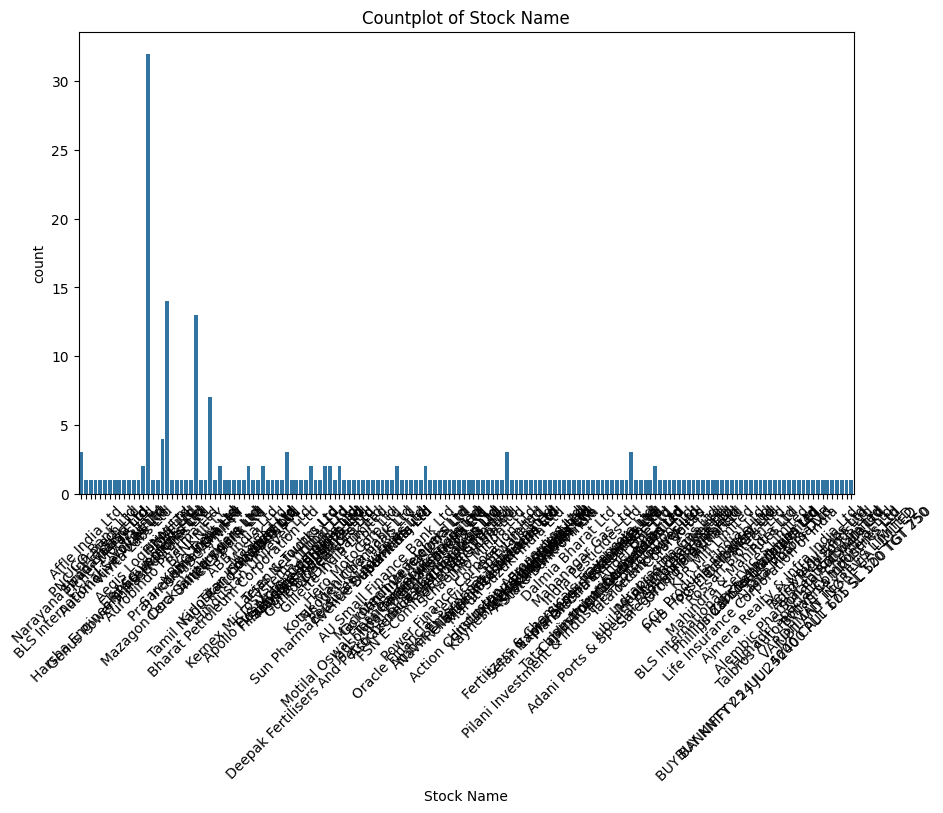

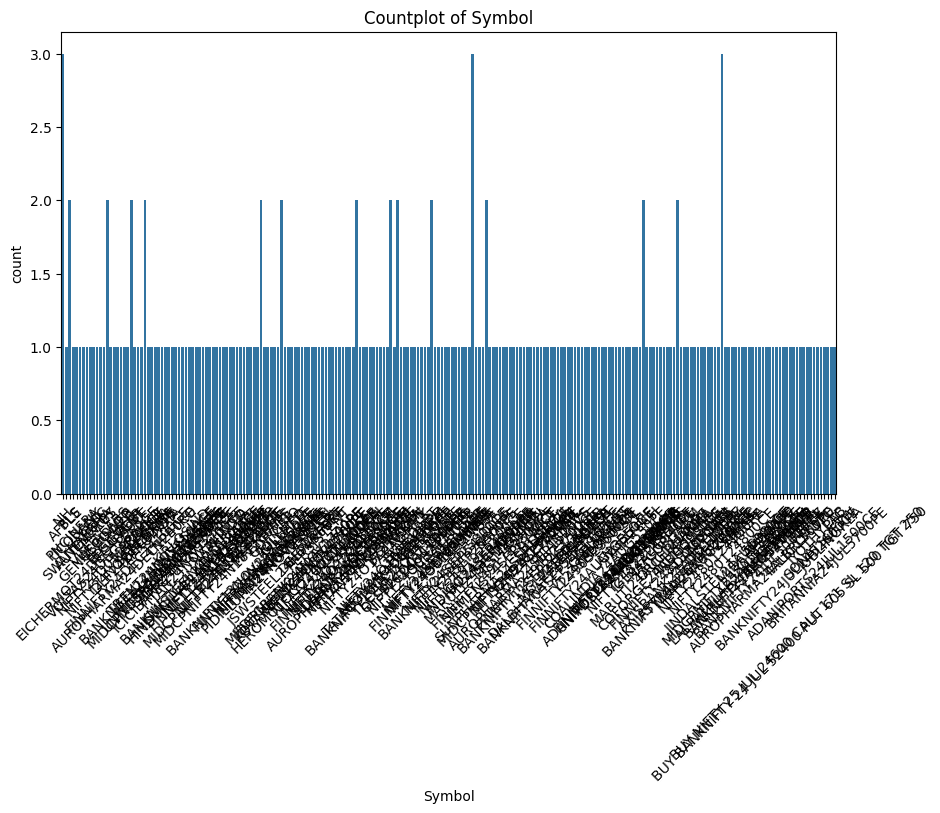

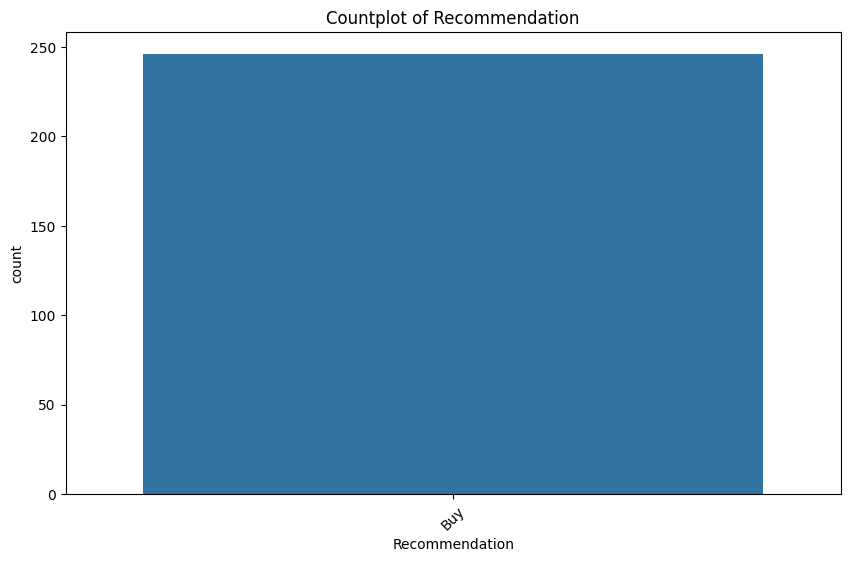

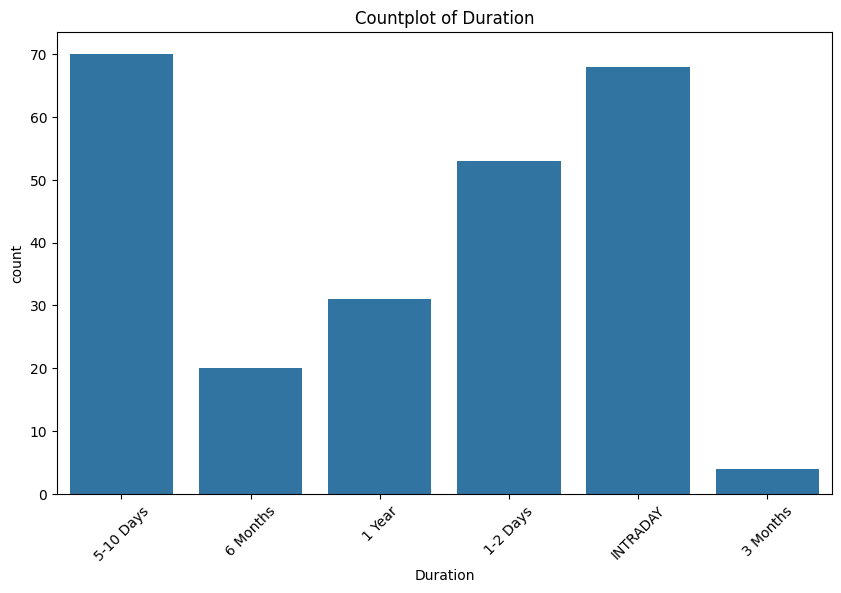

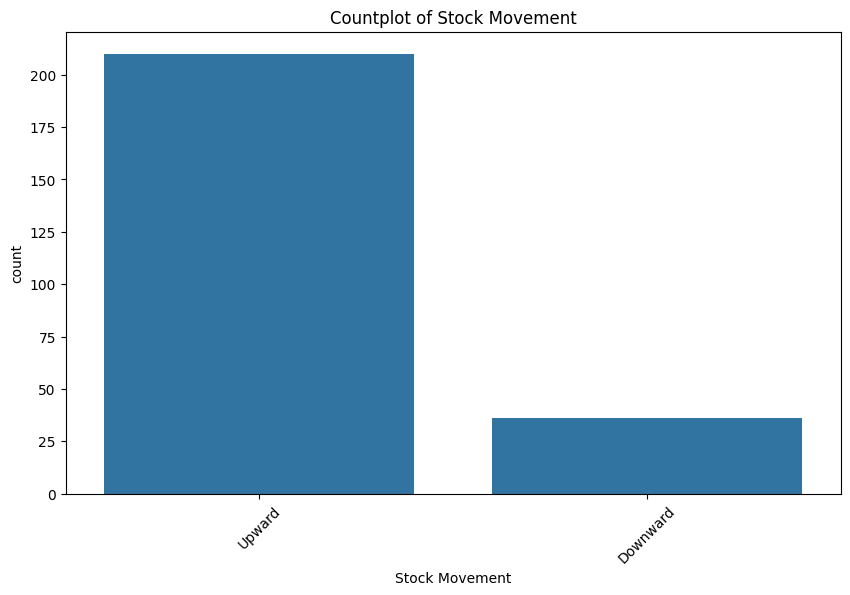

In [31]:
categorical_features = df.select_dtypes(include=[object]).columns
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature)
    plt.title(f'Countplot of {feature}')
    plt.xticks(rotation=45)
    plt.show()

In [35]:
categorical_features

Index(['Stock Name', 'Symbol', 'Recommendation', 'Duration', 'Stock Movement'], dtype='object')